In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# get the pp data and hh_data
# classify based on the hh_type
data_folder = "data/pp_check"

In [3]:
hh_ipu = pd.read_csv(f"{data_folder}/syn_hh_ipu.csv") # use the mapping from seed directly

seed_hh = pd.read_csv(f"{data_folder}/hh_sample_ipu.csv")
seed_pp = pd.read_csv(f"{data_folder}/pp_sample_ipu.csv")

hh_csp = pd.read_csv(f"{data_folder}/syn_hh_ipf.csv")

pp_csp_seed = pd.read_csv(f"{data_folder}/csp_results_allz.csv")
pp_csp_bn = pd.read_csv(f"{data_folder}/csp_BN_from_IPF.csv")

pp_bn = pd.read_csv(f"{data_folder}/syn_pp_bn_hhsz_constraint.csv")

pp_ctgan = pd.read_csv(f"{data_folder}/syn_pp_ctgan_hhsz_constraint.csv")

hh_bn = pd.read_csv(f"{data_folder}/pure_BN_HH.csv")
pp_bn_csp_bn = pd.read_csv(f"{data_folder}/csp_BN_from_BN.csv")

pure_bn_hhtype = pd.read_csv(f"{data_folder}/hh_pureBN_hhtype_filter.csv")

In [4]:
assert set(seed_hh["serialno"]) == set(seed_pp["serialno"]), "The columns of the two hh dataframes are not the same"

In [5]:
seed_pp["relationship"].unique()

array(['Main', 'Spouse', 'Child', 'Parent', 'Sibling', 'Others',
       'Grandchild', 'Grandparent'], dtype=object)

In [6]:
def get_hh_type(ids_to_map: pd.Series, pp_data: pd.DataFrame, id_col: str="serialno", rela_col: str="relationship") -> pd.Series:
    pp_data_gb = pp_data.groupby(id_col)[rela_col].apply(list).reset_index(name=rela_col)
    def classify_hh_type(relationships):
        if "Main" not in relationships:
            raise ValueError("Main person not found in relationships")
        n_pp = len(relationships)
        if n_pp == 1:
            return "Single Person"
        if "Others" in relationships:
            return "Group Household"
        if set(relationships) == {"Main", "Spouse"}:
            return "Couple Only"
        if set(relationships) == {"Main", "Child"}:
            return "Single Parent"
        if set(relationships) == {"Main", "Child", "Spouse"}:
            return "Couple with Child"
        return "Complicated Family"
    pp_data_gb["hh_type"] = pp_data_gb[rela_col].apply(classify_hh_type)
    result = pd.DataFrame(ids_to_map)
    result["hh_type"] = result[id_col].map(pp_data_gb.set_index(id_col)["hh_type"])
    return result.set_index(id_col)["hh_type"]

In [7]:
seed_mapping = get_hh_type(seed_hh["serialno"], seed_pp)
csp_seed_mapping = get_hh_type(hh_csp["serialno"], pp_csp_seed)
csp_bn_mapping = get_hh_type(hh_csp["serialno"], pp_csp_bn)
bn_mapping = get_hh_type(hh_csp["serialno"], pp_bn)
ctgan_mapping = get_hh_type(hh_csp["serialno"], pp_ctgan)
bn_csp_mapping = get_hh_type(hh_bn["serialno"], pp_bn_csp_bn)

In [8]:
seed_hh["hh_type"] = seed_hh["serialno"].map(seed_mapping)
hh_ipu["hh_type"] = hh_ipu["serialno"].map(seed_mapping)

hh_csp_seed = hh_csp.copy()
hh_csp_seed["hh_type"] = hh_csp_seed["serialno"].map(csp_seed_mapping)

hh_csp_bn = hh_csp.copy()
hh_csp_bn["hh_type"] = hh_csp_bn["serialno"].map(csp_bn_mapping)

hh_bn = hh_csp.copy()
hh_bn["hh_type"] = hh_bn["serialno"].map(bn_mapping)

hh_ctgan = hh_csp.copy()
hh_ctgan["hh_type"] = hh_ctgan["serialno"].map(ctgan_mapping)

hh_bn["hh_type"] = hh_bn["serialno"].map(bn_csp_mapping)

<Axes: title={'center': 'Distribution of Total Vehicles by HH Type (VISTA)'}>

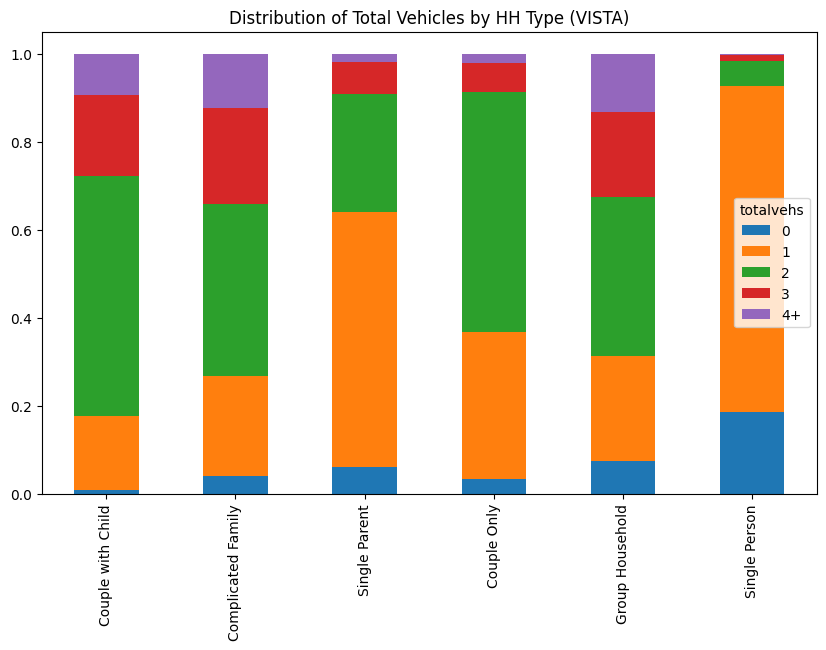

In [9]:
store = {}
for hh_type in seed_hh["hh_type"].unique():
    sub_df = seed_hh[seed_hh["hh_type"] == hh_type].copy()
    check_vehs = sub_df["totalvehs"].value_counts(normalize=True).reindex(["0", "1", "2", "3", "4+"], fill_value=0)
    store[hh_type] = check_vehs
pd.DataFrame(store).T.plot(kind="bar", stacked=True, figsize=(10, 6), title="Distribution of Total Vehicles by HH Type (VISTA)")

In [10]:
# Update to sort only if all HH Types are strings and avoid TypeError due to mixed types
def plot_grouped_stacked_vehs_by_hhtype(dfs_dict, vehicle_col="totalvehs", hhtype_col="hh_type", vehicle_order=None, title="Distribution of Total Vehicles by HH Type"):
    # Normalize and structure the data
    results = []
    for label, df in dfs_dict.items():
        for hh_type in df[hhtype_col].dropna().unique():
            sub_df = df[df[hhtype_col] == hh_type]
            norm_counts = sub_df[vehicle_col].value_counts(normalize=True).reindex(vehicle_order, fill_value=0)
            for vehs, value in norm_counts.items():
                results.append({
                    "Method": label,
                    "HH Type": hh_type,
                    "Vehicles": vehs,
                    "Proportion": value
                })

    plot_df = pd.DataFrame(results)

    # Ensure consistent category ordering only if safe
    hh_types = sorted([str(x) for x in plot_df["HH Type"].unique()])
    plot_df["HH Type"] = pd.Categorical(plot_df["HH Type"], ordered=True, categories=hh_types)
    plot_df["Method"] = pd.Categorical(plot_df["Method"], ordered=True, categories=sorted(dfs_dict.keys()))

    # Create multi-indexed table: rows = [HH Type, Method], columns = vehicle bins
    pivot_df = plot_df.pivot_table(index=["HH Type", "Method"], columns="Vehicles", values="Proportion", fill_value=0)

    # Plot with household type grouping and methods shown side-by-side
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(16, 7), colormap="tab20")
    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Household Type and Method")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [11]:
dfs_dict = {
    "VISTA": seed_hh,
    "IPU": hh_ipu, 
    "CSP-Seed": hh_csp_seed,
    "Pure BN": pure_bn_hhtype,
    # "CSP-BN": hh_csp_bn,
    # "BN": hh_bn,
    "CTGAN": hh_ctgan,
    # "BN-CSP-BN": hh_bn
    }

In [12]:
# plot_grouped_stacked_vehs_by_hhtype(dfs_dict, vehicle_order=["0", "1", "2", "3", "4+"])

In [13]:
hhinc_order = [
    "Nil income",
    "1-149",
    "150-299",
    "300-399",
    "400-499",
    "500-649",
    "650-799",
    "800-999",
    "1000-1249",
    "1250-1499",
    "1500-1749",
    "1750-1999",
    "2000-2499",
    "2500-2999",
    "3000-3499",
    "3500-3999",
    "4000-4499",
    "4500-4999",
    "5000-5999",
    "6000-7999",
    "8000+"
]
vehs_order = ["0", "1", "2", "3", "4+"]

In [14]:
# store = {}
# for hh_type in seed_hh["hh_type"].unique():
#     print(hh_type)
#     sub_df = seed_hh[seed_hh["hh_type"] == hh_type].copy()
#     check_inc = sub_df["hhinc"].value_counts(normalize=True).reindex(hhinc_order, fill_value=0)
#     check_inc = check_inc.drop(["Nil income"])
#     store[hh_type] = check_inc
# pd.DataFrame(store).plot(kind="line", figsize=(15, 6), title="Distribution of Household Income by HH Type (VISTA)")

In [15]:
# store = {}
# for hh_type in seed_hh["hh_type"].unique():
#     print(hh_type)
#     sub_df = seed_hh[seed_hh["hh_type"] == hh_type].copy()
#     check_inc = sub_df["totalvehs"].value_counts(normalize=True).reindex(["0", "1", "2", "3", "4+"], fill_value=0)
#     store[hh_type] = check_inc
# pd.DataFrame(store).plot(kind="line", figsize=(15, 6), title="Distribution of total vehs by HH Type (VISTA)")

In [16]:
from scipy.interpolate import make_interp_spline
import numpy as np

def check_dist_hh_type(dict_dfs, hh_type, att, orders, smooth=True):
    """
    Plot household att distribution for a given household type across multiple datasets.

    Parameters:
    - dict_dfs: dict of DataFrames, each with 'hh_type' and the specified attribute
    - hh_type: the specific household type to filter by
    - atts: the column name for check
    - orders: ordered list of categories
    - smooth: whether to apply smoothing to the lines (default: True)
    """
    store = {}
    for name, df in dict_dfs.items():
        sub_df = df[df["hh_type"] == hh_type].copy()
        check = sub_df[att].value_counts(normalize=True).reindex(orders, fill_value=0)
        if "Nil income" in check.index:
            check = check.drop("Nil income")
        store[name] = check

    df = pd.DataFrame(store)
    x_labels = df.index.tolist()
    x_numeric = np.arange(len(x_labels))

    plt.figure(figsize=(15, 6))

    for col in df.columns:
        y = df[col].values
        if smooth and len(x_numeric) >= 4:  # Ensure enough points for cubic spline
            x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            y_smooth = make_interp_spline(x_numeric, y, k=3)(x_smooth)
            plt.plot(x_smooth, y_smooth, label=col)
        else:
            plt.plot(x_numeric, y, marker='o', label=col)

    plt.xticks(ticks=x_numeric, labels=x_labels, rotation=45, ha='right')
    plt.title(f"Household {att} Distribution by HH Type ({hh_type})")
    plt.xlabel(att)
    plt.ylabel("Proportion")
    plt.legend()
    plt.tight_layout()
    plt.show()

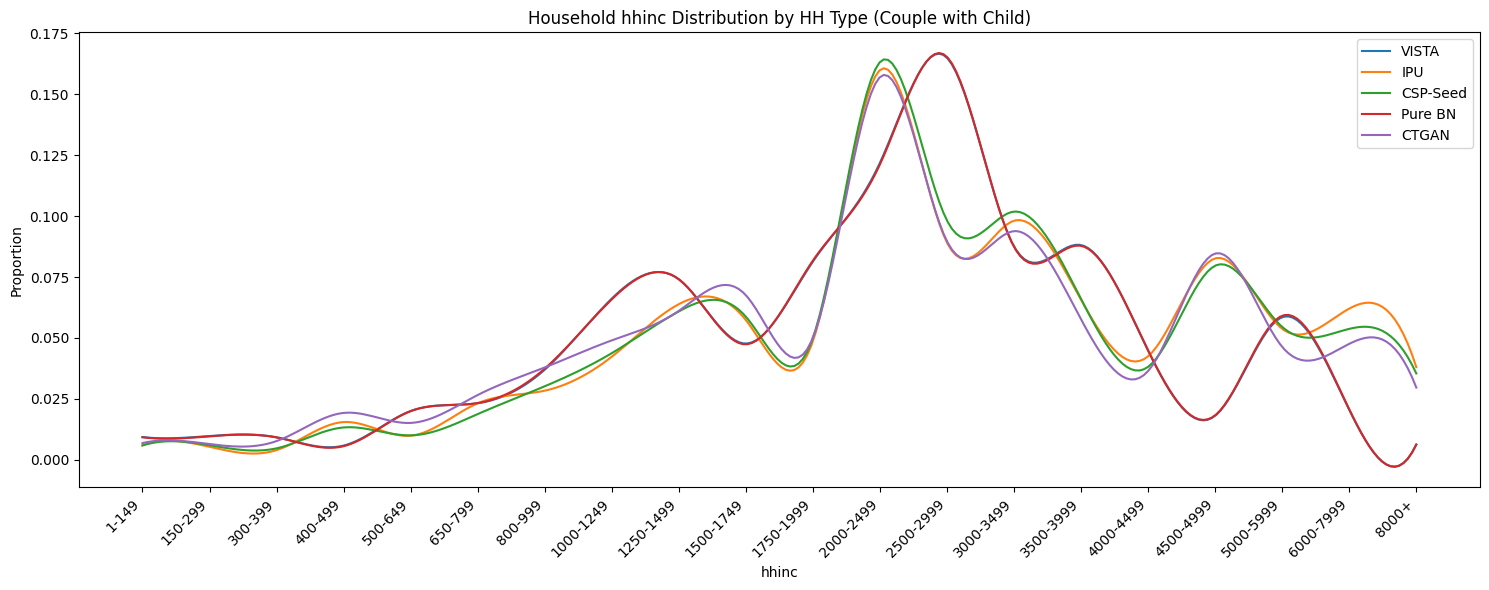

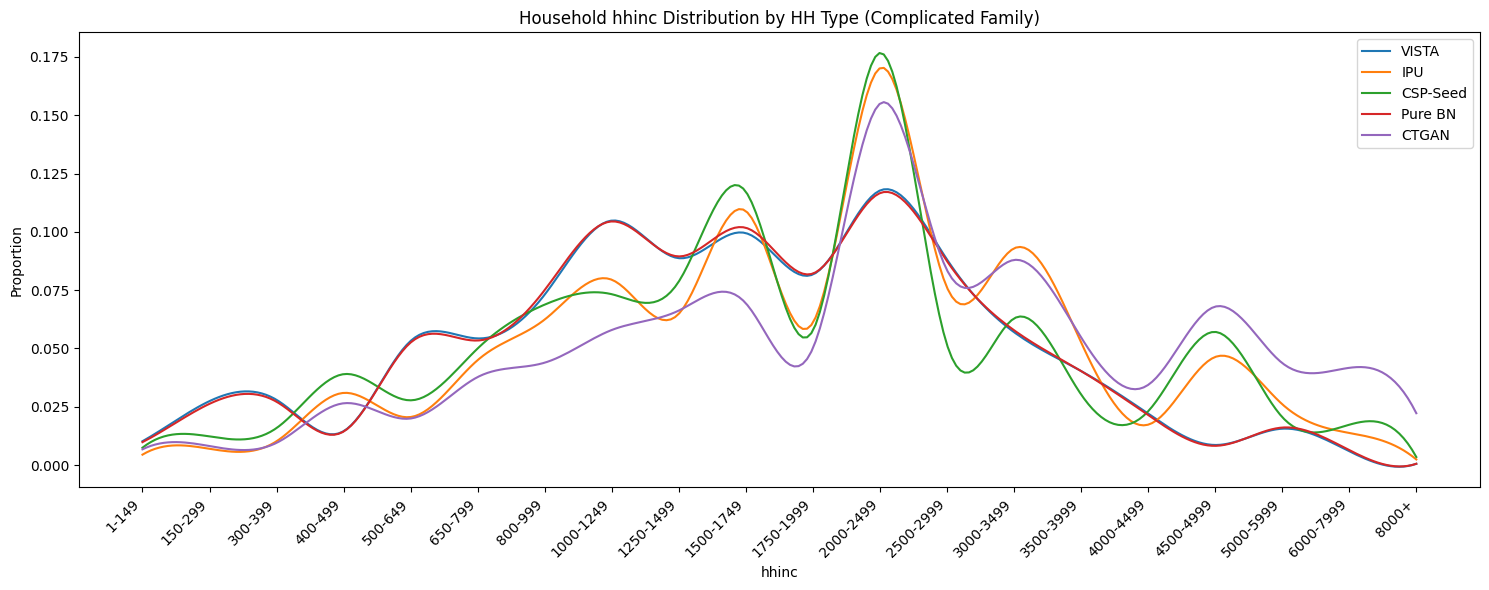

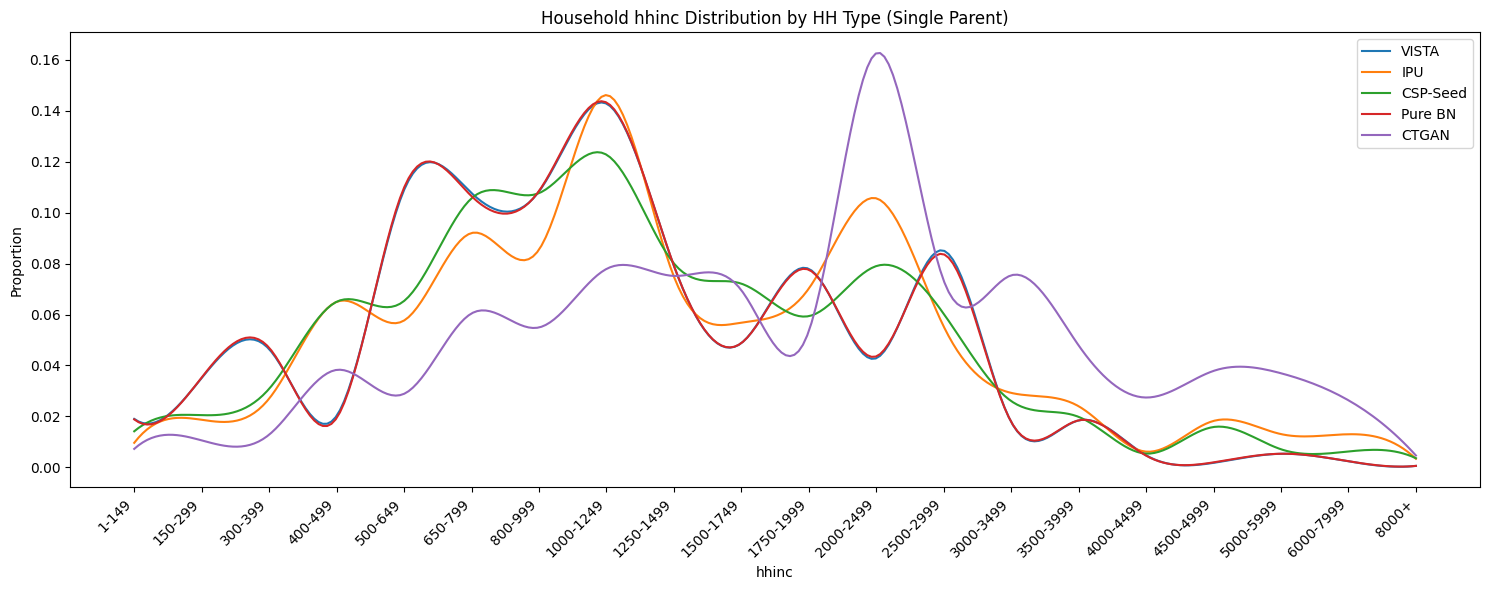

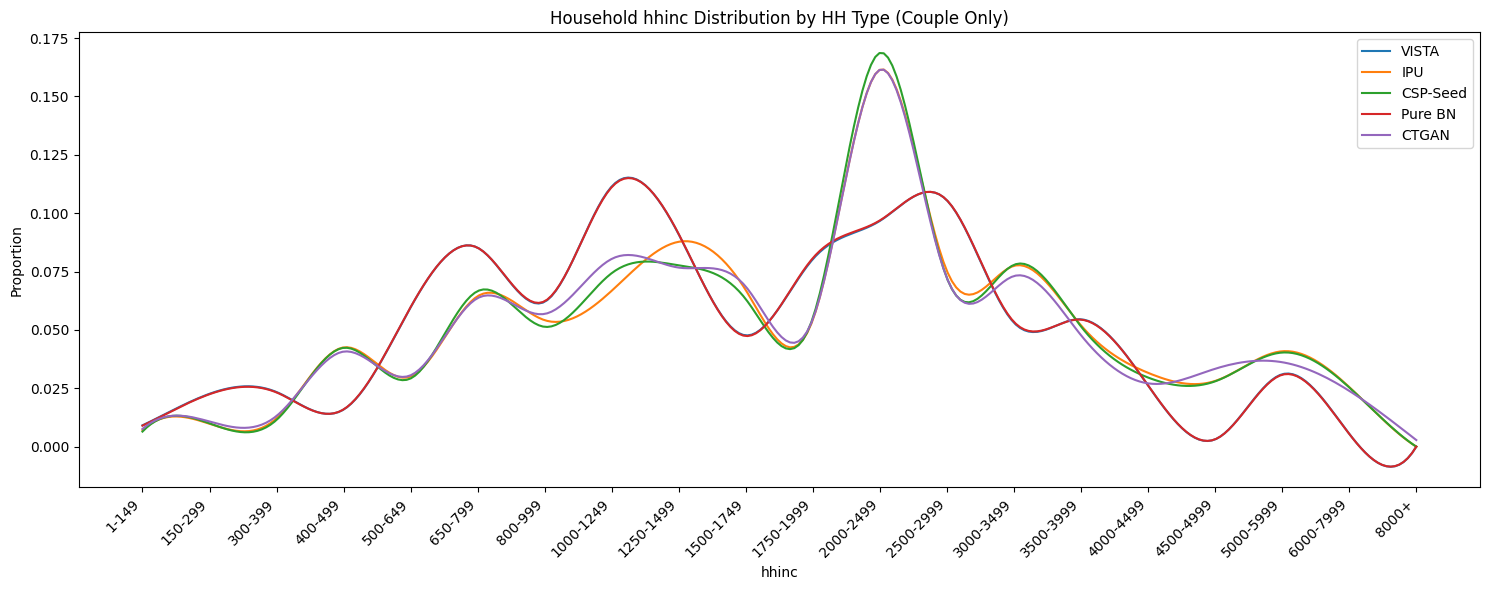

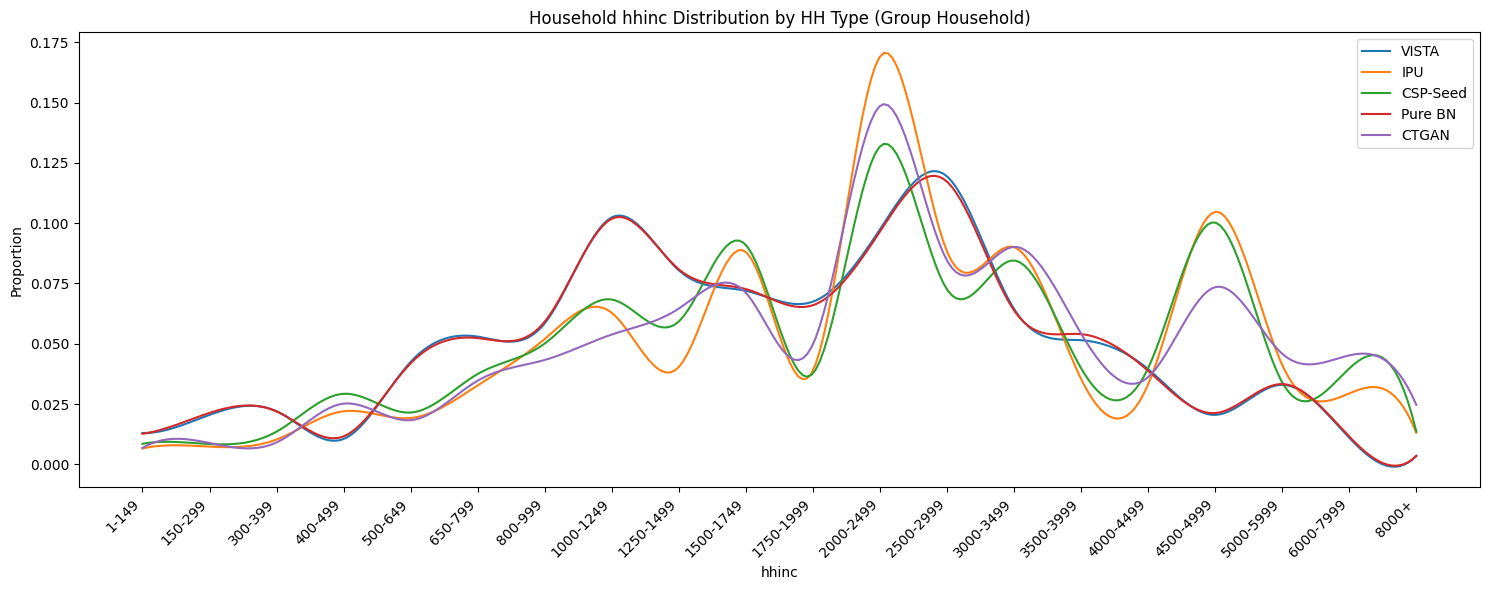

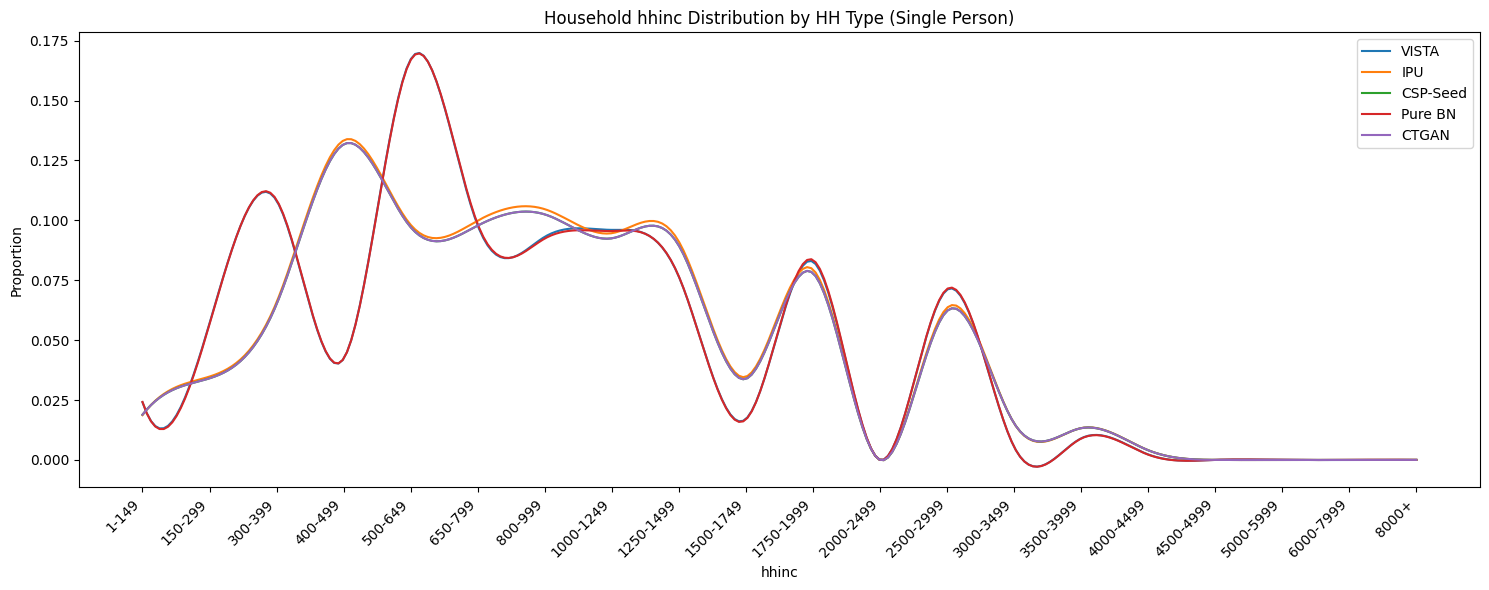

In [17]:
# hhinc
for hhtype in seed_hh["hh_type"].unique():
    check_dist_hh_type(dfs_dict, hhtype, "hhinc", hhinc_order)

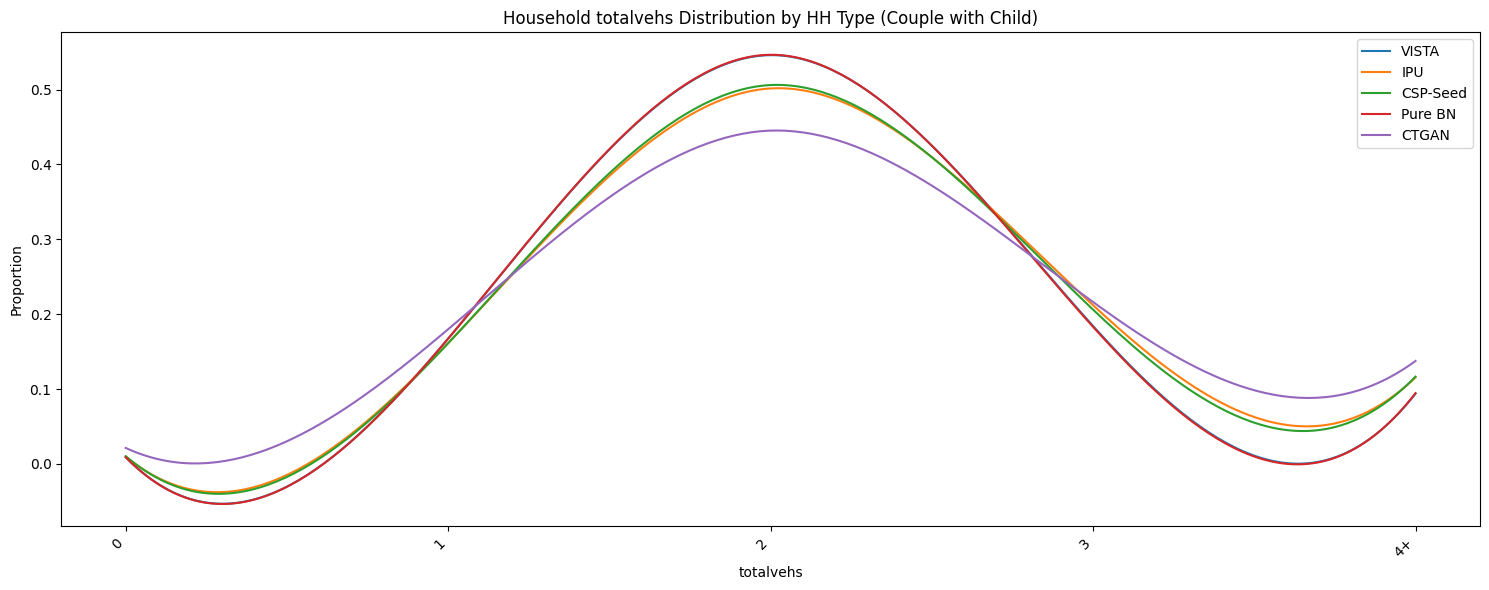

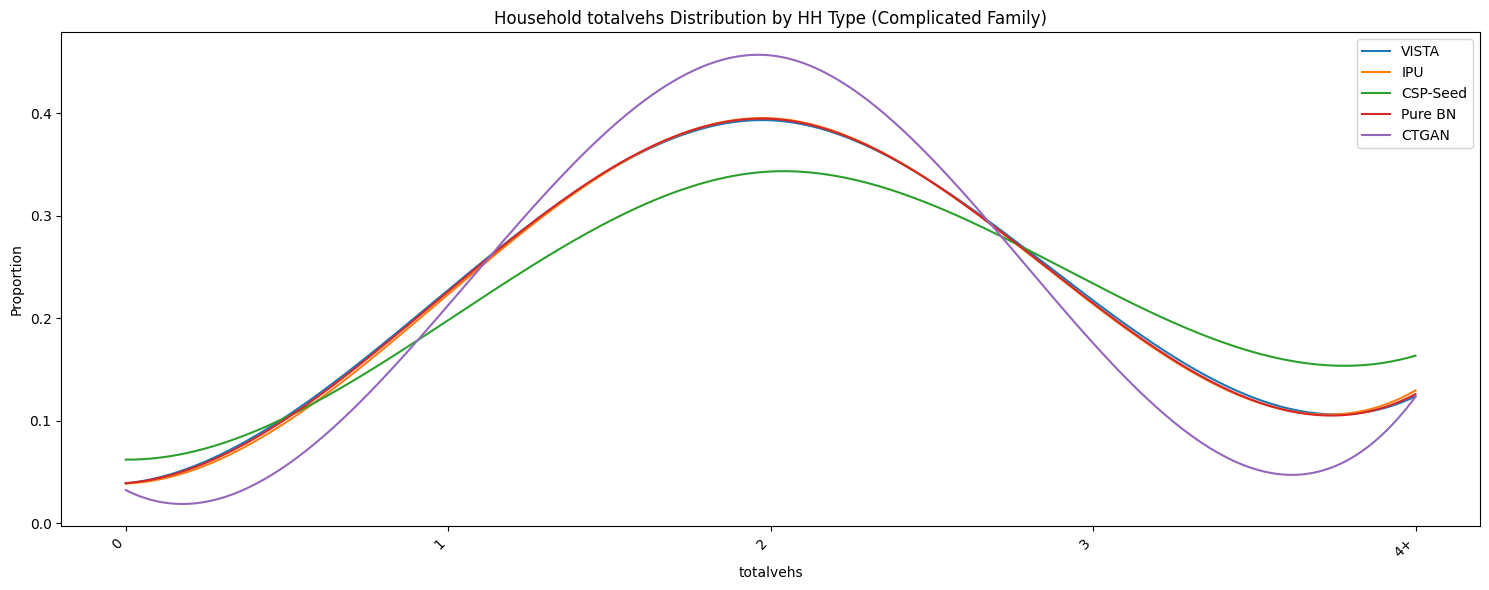

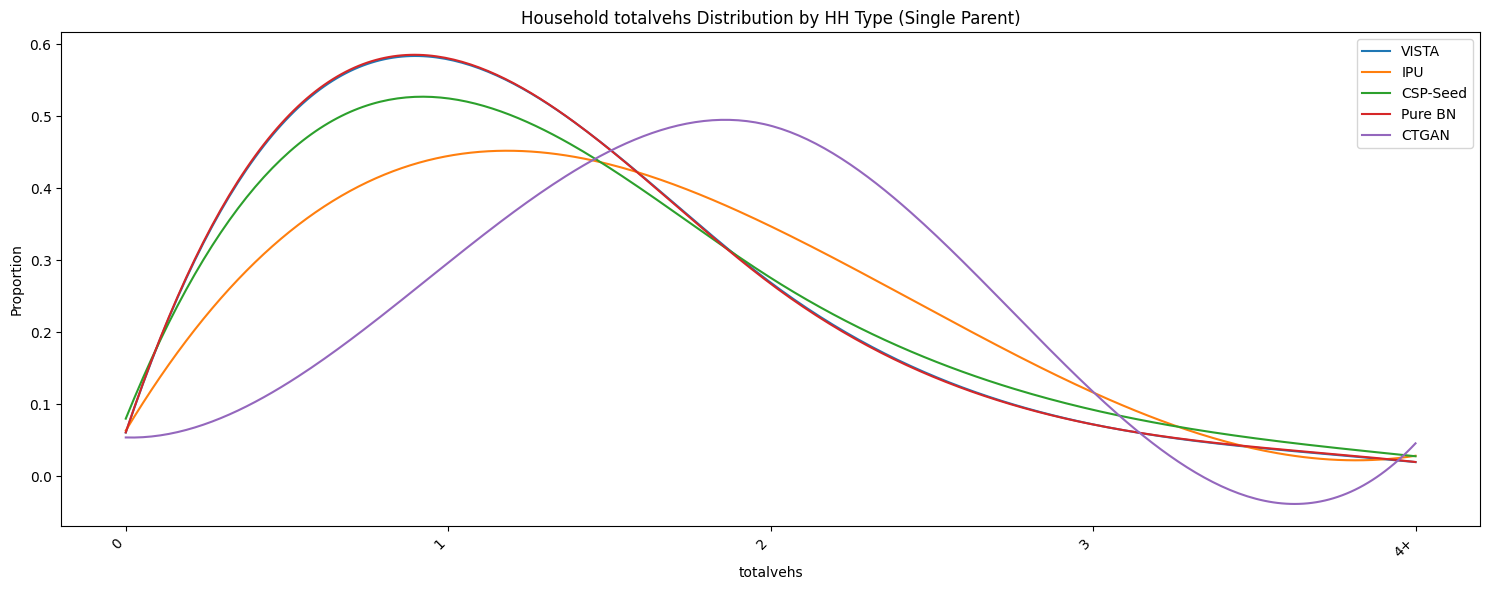

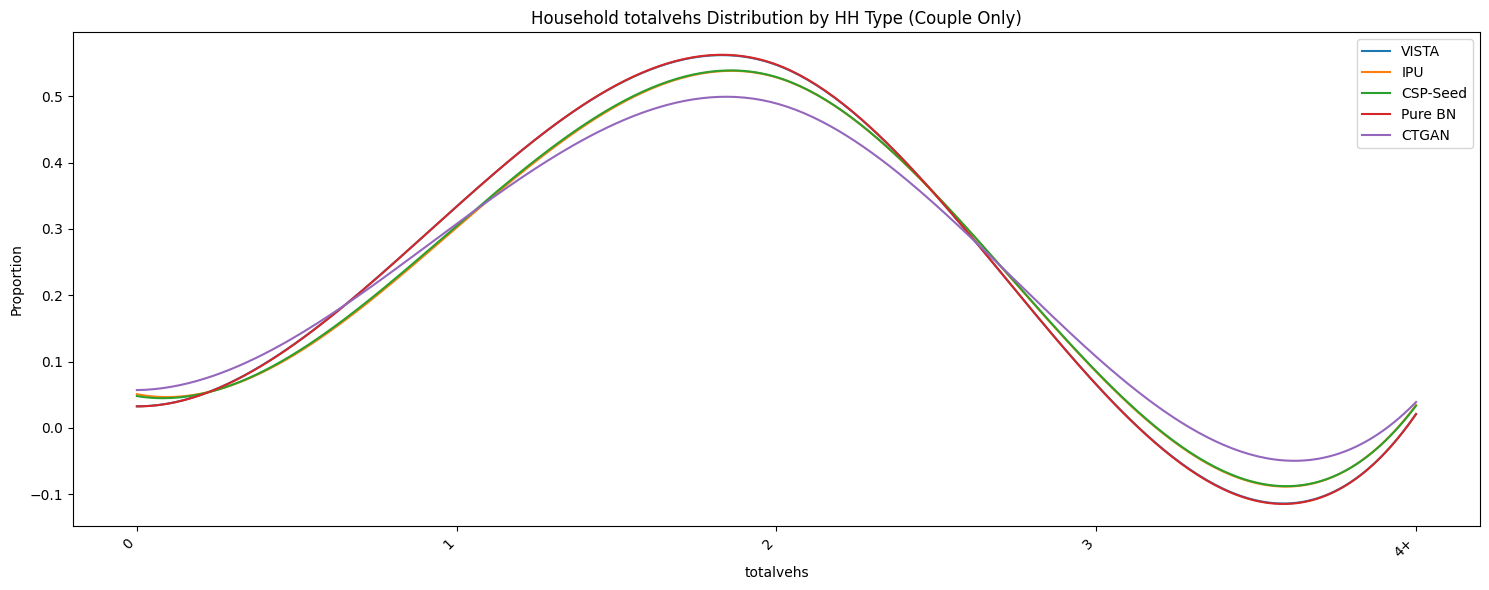

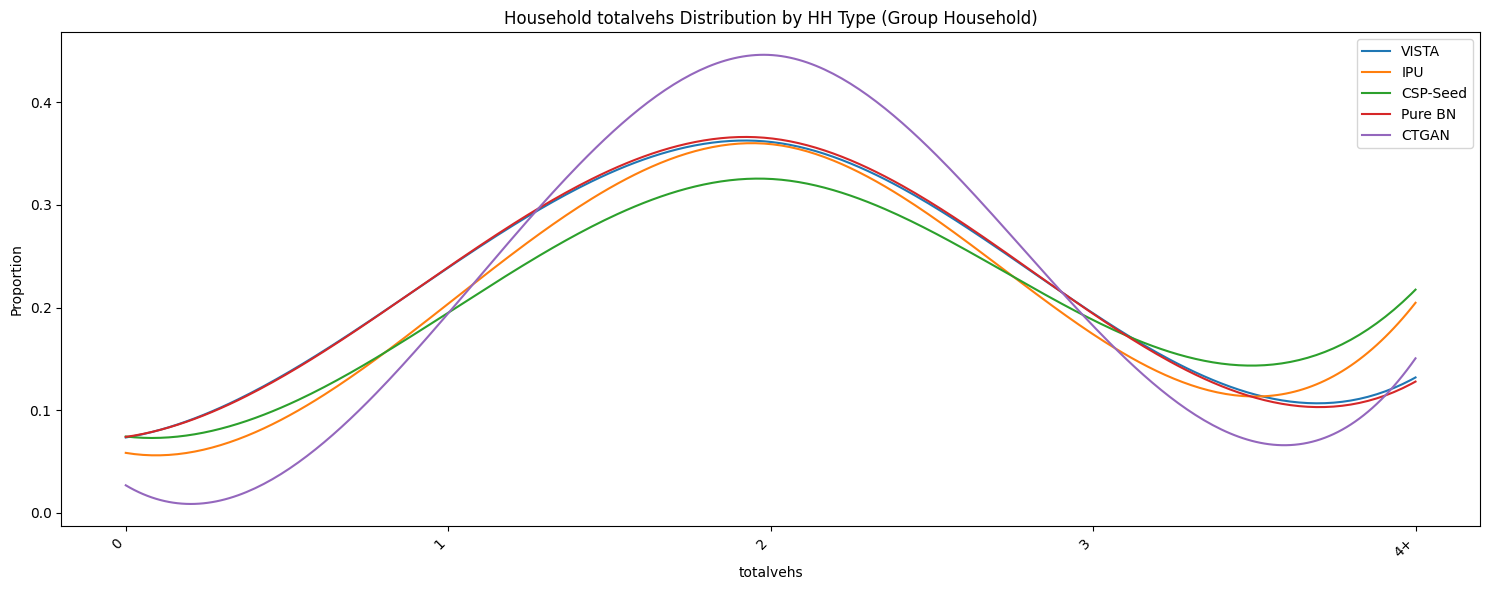

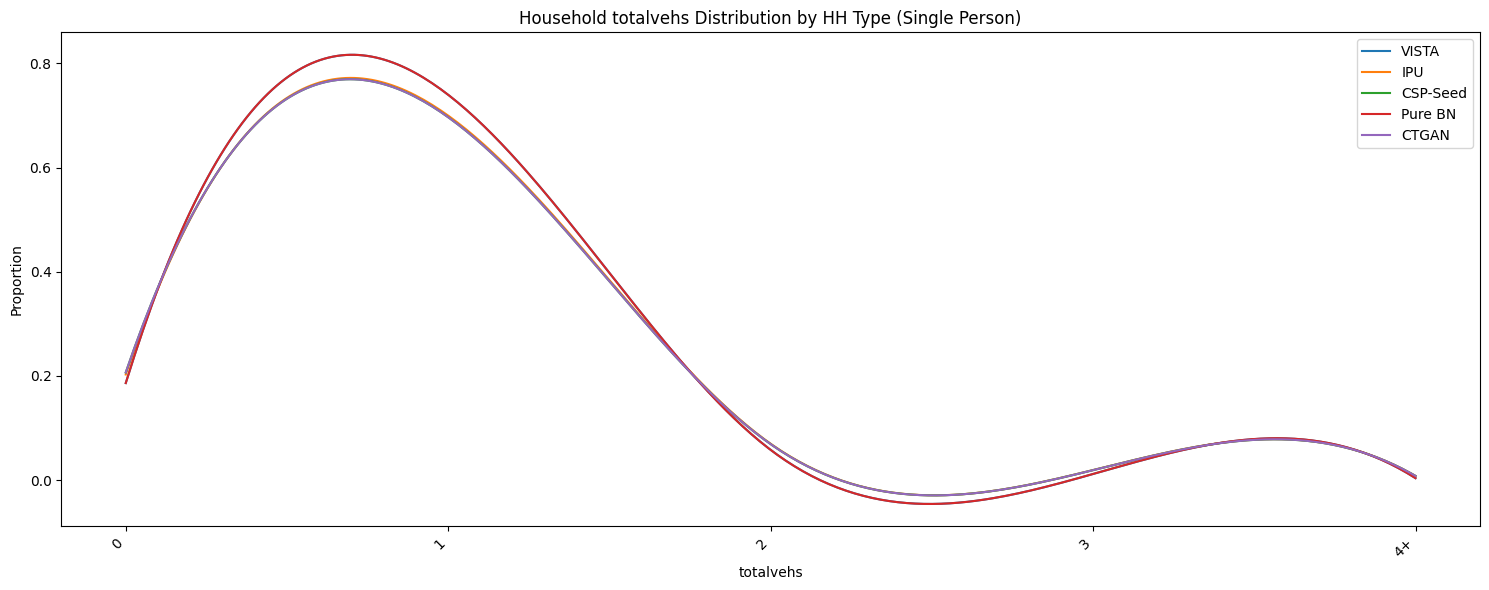

In [18]:
# check totalvehs
for hhtype in seed_hh["hh_type"].unique():
    check_dist_hh_type(dfs_dict, hhtype, "totalvehs", vehs_order)

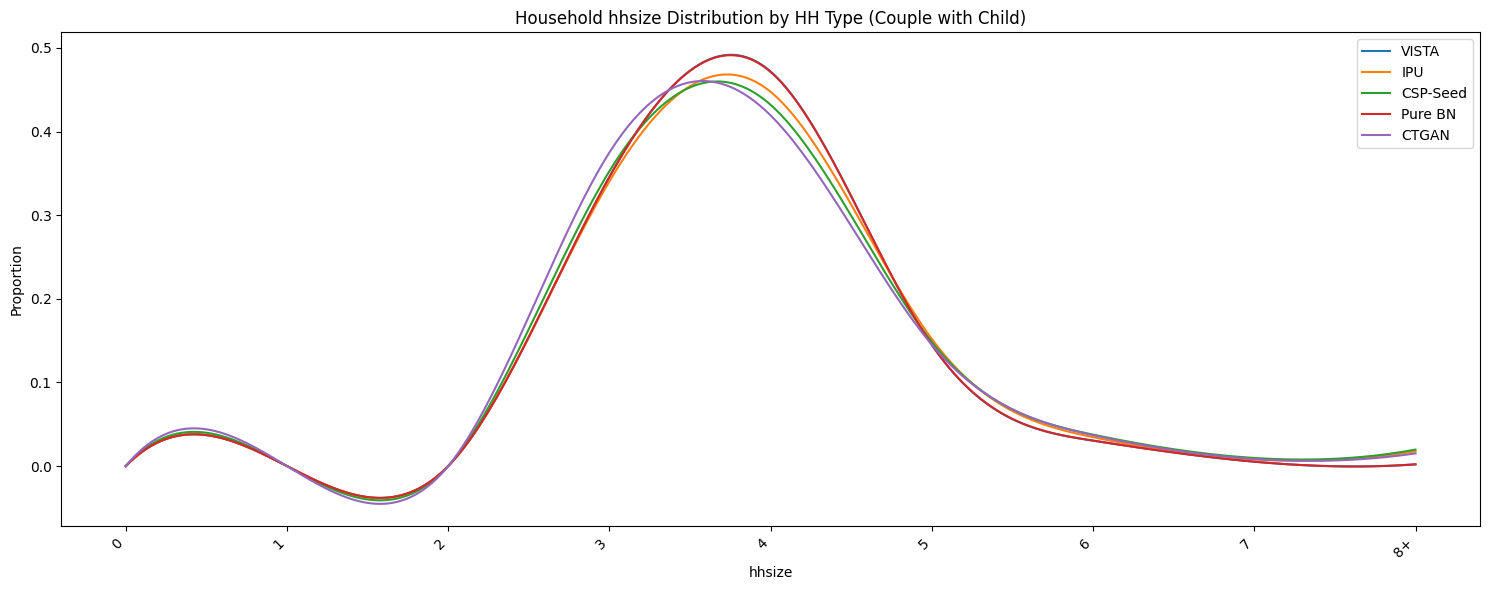

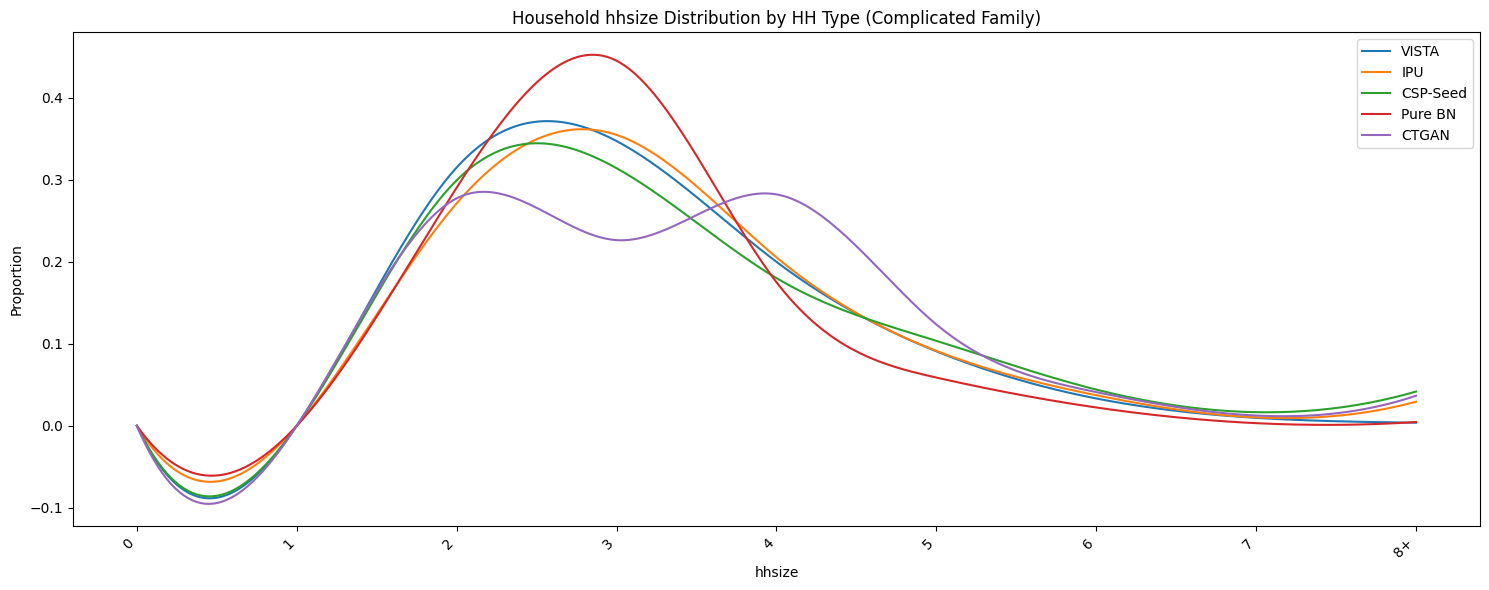

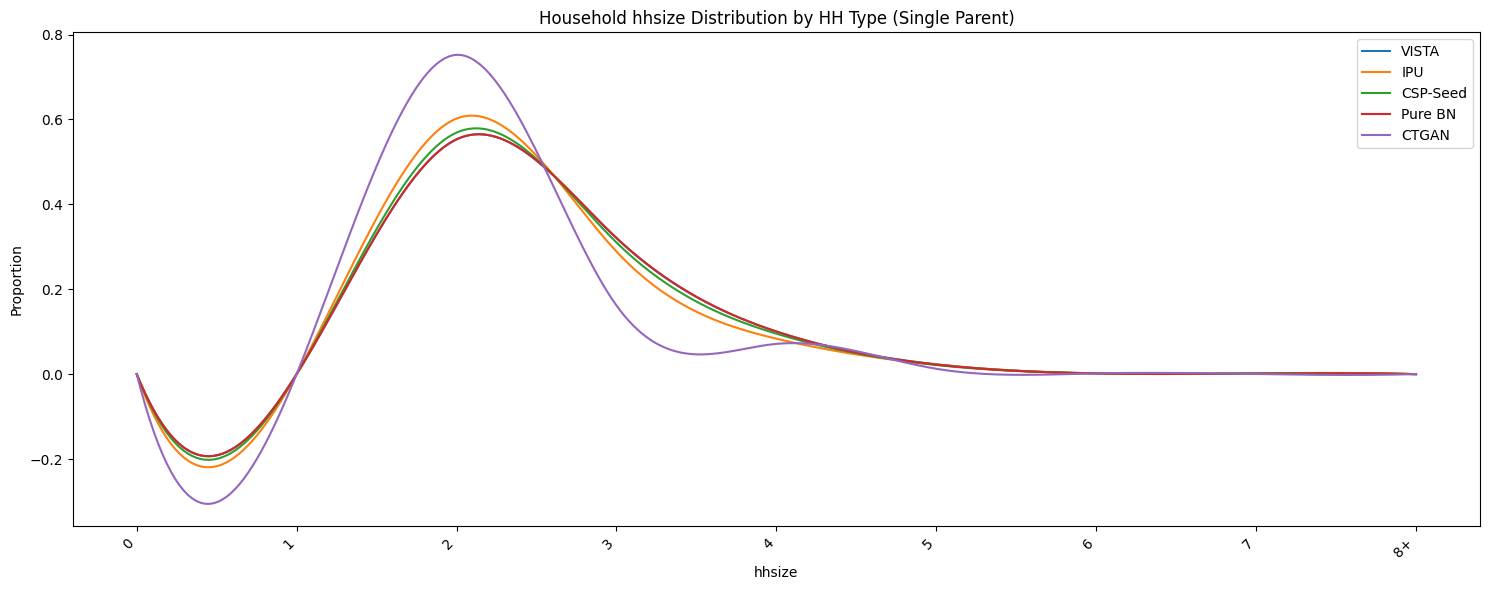

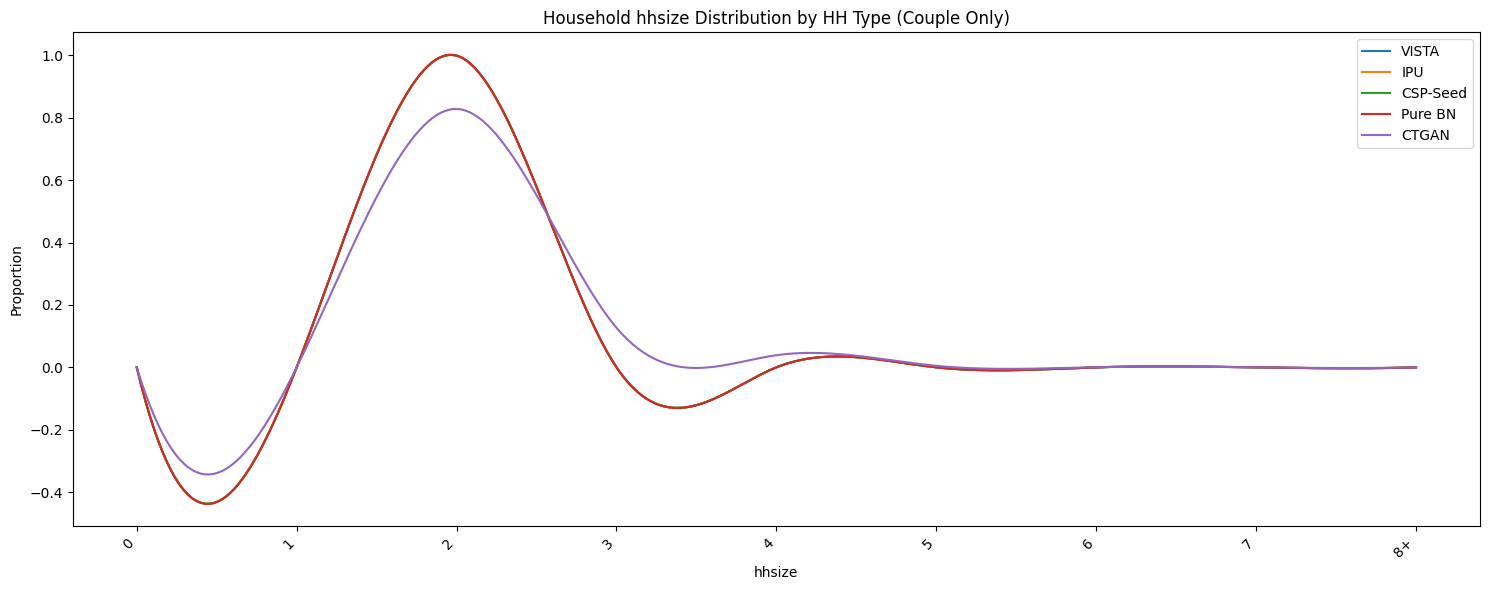

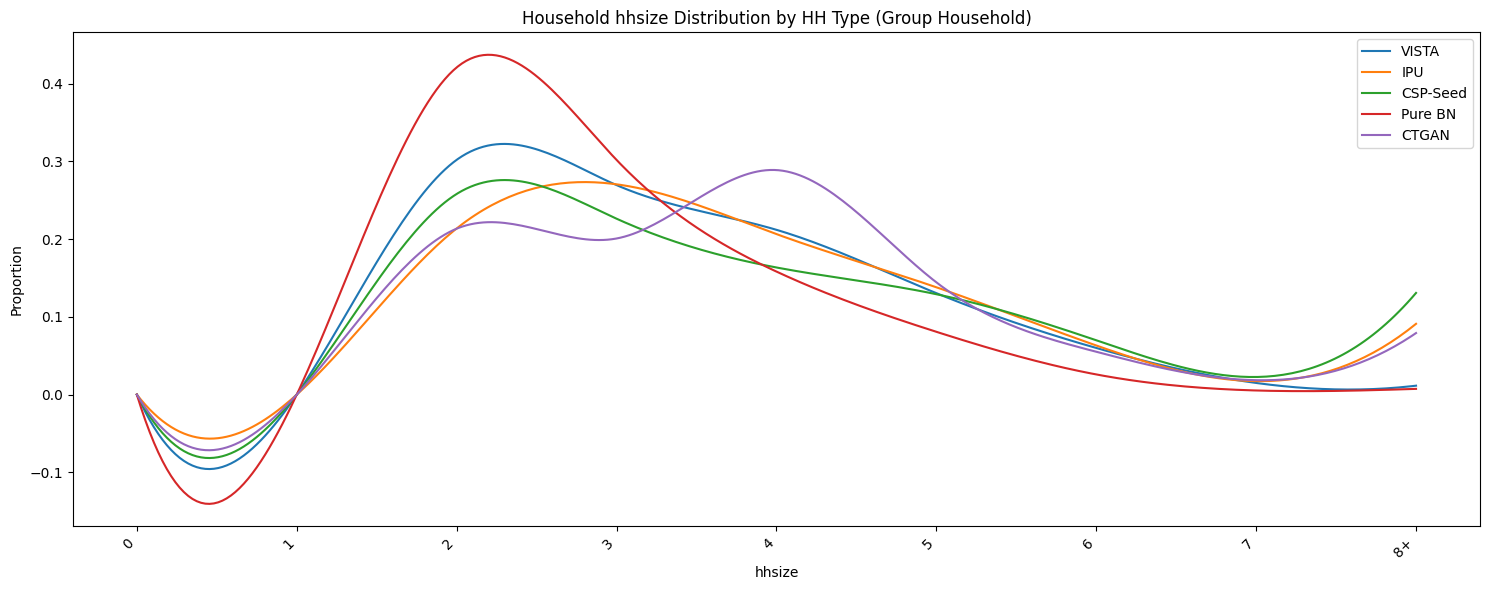

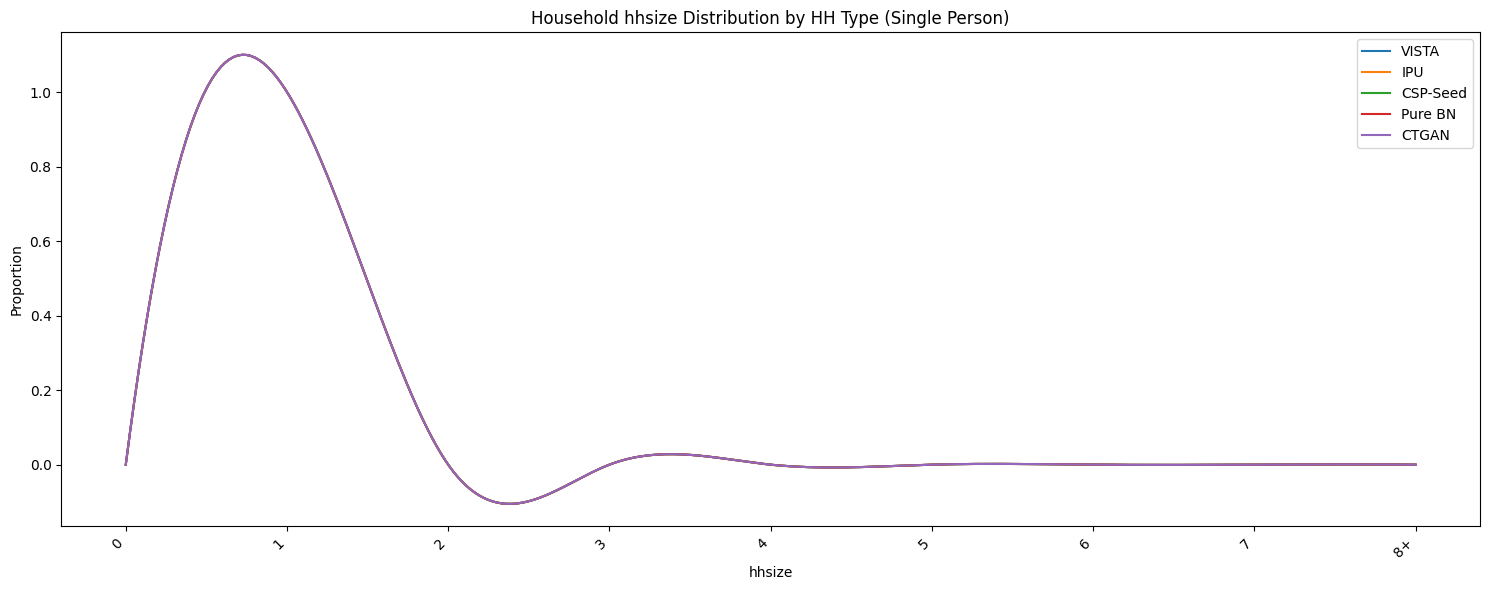

In [19]:
# check totalvehs
for hhtype in seed_hh["hh_type"].unique():
    check_dist_hh_type(dfs_dict, hhtype, "hhsize", ["0", "1", "2", "3", "4", "5", "6", "7", "8+"])

<Axes: title={'center': 'Distribution of Household Types by Method'}, xlabel='hh_type'>

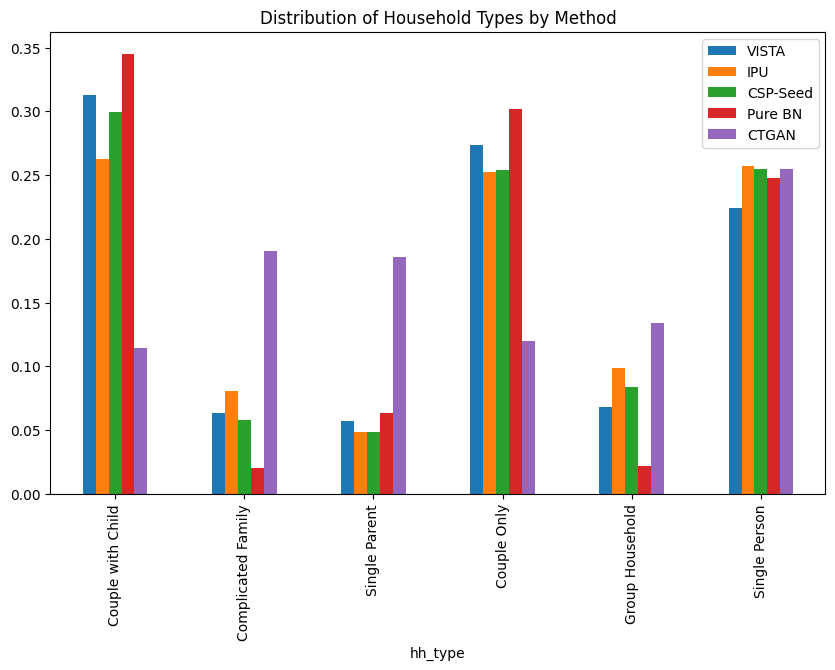

In [20]:
store = {}
for name, df in dfs_dict.items():
    store[name] = df["hh_type"].value_counts(normalize=True).reindex(seed_hh["hh_type"].unique(), fill_value=0)
pd.DataFrame(store).plot(kind="bar", figsize=(10, 6), title="Distribution of Household Types by Method")

In [21]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

def compute_jsd(p, q):
    """Safe computation of Jensen-Shannon Distance"""
    return jensenshannon(p, q, base=2)

def get_jsd_table(dict_dfs, hh_types, atts):
    """
    Compute Jensen-Shannon Distance table for multiple household types and attributes.

    Parameters:
    - dict_dfs: dict of DataFrames (must include 'VISTA' as ground truth)
    - hh_types: list of household types to include
    - atts: list of attribute names to compare

    Returns:
    - MultiIndex DataFrame: (hh_type, attribute) as rows, dataset names as columns
    """
    assert "VISTA" in dict_dfs, "'VISTA' must be present as the ground truth"

    data = []

    for hh_type in hh_types:
        for att in atts:
            vista_df = dict_dfs["VISTA"]
            vista_sub = vista_df[vista_df["hh_type"] == hh_type]
            vista_counts = vista_sub[att].value_counts(normalize=True)

            jsd_scores = {}
            for name, df in dict_dfs.items():
                if name == "VISTA":
                    continue
                sub_df = df[df["hh_type"] == hh_type]
                dist_counts = sub_df[att].value_counts(normalize=True)

                all_cats = set(vista_counts.index).union(dist_counts.index)
                vista_aligned = vista_counts.reindex(all_cats, fill_value=0).values
                dist_aligned = dist_counts.reindex(all_cats, fill_value=0).values

                jsd = compute_jsd(vista_aligned, dist_aligned)
                jsd_scores[name] = jsd

            # Append to results list as a row
            data.append(((hh_type, att), jsd_scores))

    # Convert to DataFrame
    index = pd.MultiIndex.from_tuples([key for key, _ in data], names=["HH Type", "Attribute"])
    result_df = pd.DataFrame([vals for _, vals in data], index=index)

    return result_df


In [22]:
a = get_jsd_table(dfs_dict, seed_hh["hh_type"].unique(), [x for x in seed_hh.columns if x not in ["serialno", "hh_type", "sample_geog"]])

<Axes: title={'center': 'Mean JSD per HH Type'}>

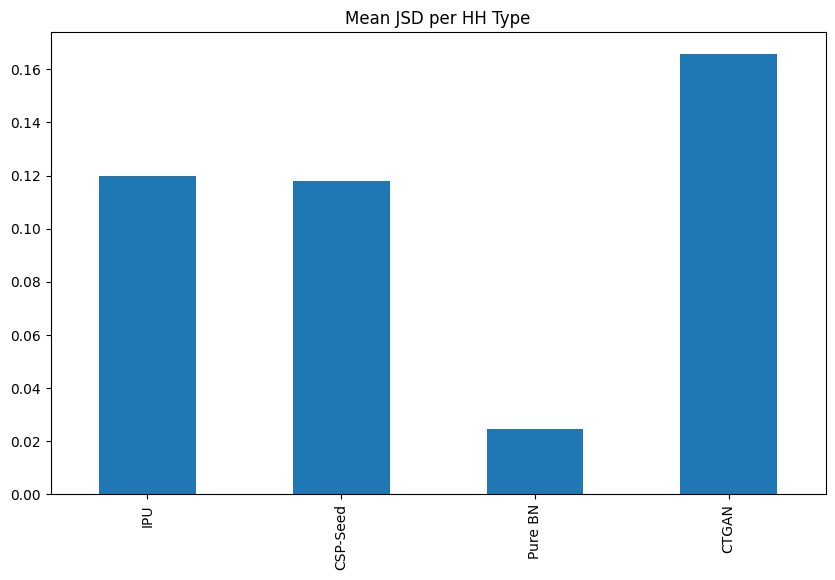

In [23]:
mean_jsd_per_hhtype = a.groupby(level="HH Type").mean()
mean_jsd_per_hhtype.mean().plot(kind="bar", figsize=(10, 6), title="Mean JSD per HH Type")

<Axes: title={'center': 'Mean JSD by HH Type'}, xlabel='Household Type', ylabel='Mean JSD'>

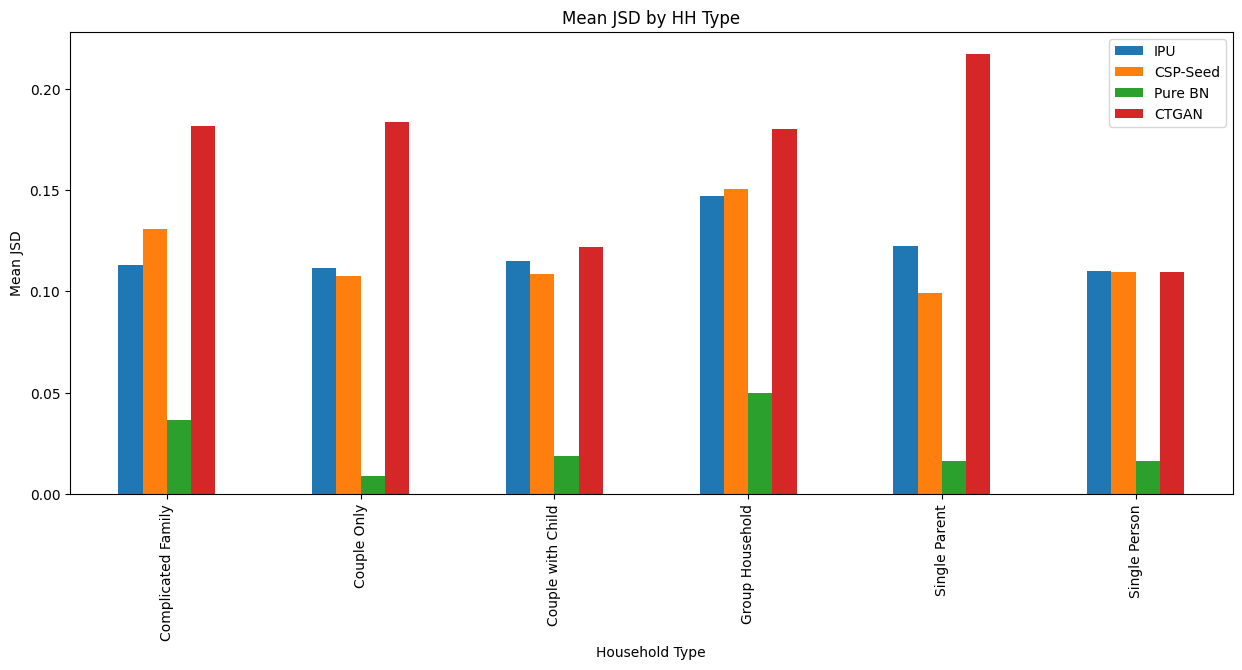

In [24]:
mean_jsd_per_hhtype.plot(kind="bar", figsize=(15, 6), title="Mean JSD by HH Type", ylabel="Mean JSD", xlabel="Household Type")